In [1]:
import numpy as np
import keras as K
import matplotlib.pyplot as plt
#import torch

Using TensorFlow backend.


# N-Net with Adverserial Sub-Nets

We'll use MNIST as an example, but this should generalize

## Data Pre-Processing

In [2]:
(x_train, y_train), (x_test, y_test) = K.datasets.mnist.load_data()

In [3]:
IMAGE_SHAPE = x_train.shape[1:]

Scale from 255 grayscale to `[0,1]`

In [4]:
x_train, x_test  = x_train/255.0, x_test/255.0

Convert labels to one-hot representation

In [5]:
y_train_oh = K.utils.to_categorical(y_train, 10)

In [6]:
y_test_oh = K.utils.to_categorical(y_test, 10)

## Image Plotting Function

In [7]:
def plot_image(d, l):
    print("Label {}".format(l))
    plt.figure(figsize=(2,2))
    plt.imshow(d.reshape(IMAGE_SHAPE)*255, cmap='gray')

In [8]:
def printer(n, test=False):
    if test:
        plot_image(x_test[n], y_test[n])
    else:
        plot_image(x_train[n], y_train[n])
    plt.show()

Label 4


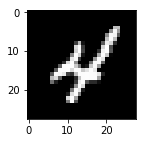

In [9]:
printer(9)

## Network Structure

Input Layers are Standard, a batch input and flatten the 2d images

In [10]:
in_layer = K.layers.Input(shape=IMAGE_SHAPE, name='Input')

In [11]:
flatten = K.layers.Flatten()(in_layer)

The hidden layer is a set of individual dense layers. Sigmoid allows for easier calculation of loss later

In [12]:
MODULE_SIZE = 10

In [13]:
modules = [K.layers.Dense(MODULE_SIZE, name='Mod_'+str(i), activation='sigmoid') for i in range(4)]

In [14]:
mod_out = [i(flatten) for i in modules]

Then these layers are concatenated before input into the output layer

In [15]:
concat = K.layers.Concatenate(name='Concatenate')(mod_out)

In [16]:
output = K.layers.Dense(10, name='Output', activation='softmax')(concat)

Since we are using a custom loss we'll also manually add an input layer

In [17]:
label_in = K.layers.Input((10,))

The modules are paired according to some topology that will decide how we calculate the loss

In [18]:
pairs = [(0,1), (0,2), (1,3), (2,3)]

Several step here to generate the loss

In [19]:
# out_diff = [K.layers.Subtract()([mod_out[i], mod_out[j]]) for i, j in pairs]

In [20]:
# out_dot = [K.layers.Dot(1, normalize=True)([i, i]) for i in out_diff]

In [21]:
out_diff = [K.layers.Dot(1)([mod_out[i], mod_out[j]]) for i, j in pairs]

In [22]:
dot_sum = sum(out_diff)[:, 0]/float(len(modules))

This is loss is then combined with the cross entropy between the output and supplied labels

In [23]:
loss = K.losses.categorical_crossentropy(output, label_in)-0.1*dot_sum

Finally set the model. We'll output the hidden-layer outputs for later analysis

In [24]:
model = K.Model([in_layer, label_in], [output]+mod_out)

In [25]:
model.add_loss(loss)

In [26]:
import IPython

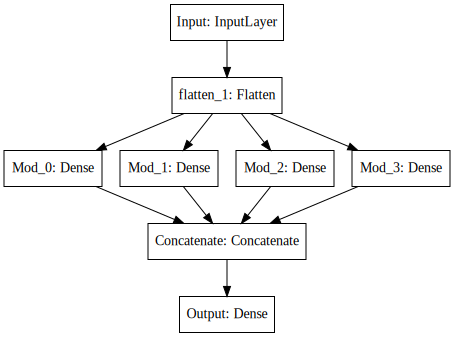

In [27]:
IPython.display.SVG(K.utils.vis_utils.model_to_dot(model).create(prog='dot', format='svg'))

In [28]:
accuracy = K.metrics.categorical_accuracy(output, label_in)

In [29]:
model.compile(optimizer ='RMSprop', metrics=[accuracy]) 

In [51]:
h = model.fit([x_train, y_train_oh], epochs=50, validation_split=0.2, verbose=2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
 - 1s - loss: 0.0638 - val_loss: 0.3450
Epoch 2/50
 - 1s - loss: 0.0642 - val_loss: 0.3424
Epoch 3/50
 - 1s - loss: 0.0641 - val_loss: 0.3510
Epoch 4/50
 - 1s - loss: 0.0665 - val_loss: 0.3412
Epoch 5/50
 - 1s - loss: 0.0658 - val_loss: 0.3544
Epoch 6/50
 - 1s - loss: 0.0666 - val_loss: 0.3569
Epoch 7/50
 - 1s - loss: 0.0641 - val_loss: 0.3540
Epoch 8/50
 - 1s - loss: 0.0680 - val_loss: 0.3538
Epoch 9/50
 - 1s - loss: 0.0652 - val_loss: 0.3523
Epoch 10/50
 - 1s - loss: 0.0707 - val_loss: 0.3550
Epoch 11/50
 - 1s - loss: 0.0717 - val_loss: 0.3553
Epoch 12/50
 - 1s - loss: 0.0703 - val_loss: 0.3613
Epoch 13/50
 - 1s - loss: 0.0729 - val_loss: 0.3590
Epoch 14/50
 - 1s - loss: 0.0797 - val_loss: 0.3559
Epoch 15/50
 - 1s - loss: 0.0771 - val_loss: 0.3599
Epoch 16/50
 - 1s - loss: 0.0771 - val_loss: 0.3606
Epoch 17/50
 - 1s - loss: 0.0805 - val_loss: 0.3650
Epoch 18/50
 - 1s - loss: 0.0790 - val_loss: 0.3624
Epoch 19/50
 - 1s - los

In [52]:
#plt.plot(np.log(h.history['loss']))
#plt.plot(np.log(h.history['val_loss']))
#plt.show();

In [53]:
res = model.predict([x_test, y_test_oh])

In [54]:
p = np.argmax(res[0], axis=1)

In [55]:
np.sum(p == y_test)/float(y_test.shape[0])

0.9175

In [56]:
from sklearn.metrics import confusion_matrix

In [57]:
cm = confusion_matrix(y_test, p)

In [58]:
cm

array([[ 929,    0,    5,   19,    6,    2,    9,    1,    6,    3],
       [   1, 1104,    2,    7,    1,    4,    2,    3,   11,    0],
       [   8,    1,  921,   52,    7,    3,    9,    9,   19,    3],
       [   0,    2,   12,  929,    0,   27,    0,   10,   24,    6],
       [   0,    0,    4,    5,  918,    0,    6,    5,    8,   36],
       [   9,    1,    1,   38,    4,  791,    6,    1,   30,   11],
       [  11,    3,    4,   24,    6,   10,  892,    1,    5,    2],
       [   0,    3,   17,   14,    4,    2,    2,  951,   18,   17],
       [  14,    6,    5,   39,   12,   26,    8,    7,  849,    8],
       [   4,    5,    1,   24,   41,    2,    0,   23,   18,  891]])

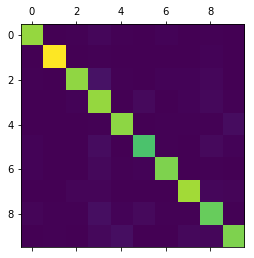

In [59]:
plt.matshow(cm);

In [73]:
W = np.stack([m.get_weights()[0] for m in modules])
W = (W-W.min())/(W.max()-W.min())

In [76]:
W.shape

(4, 784, 10)

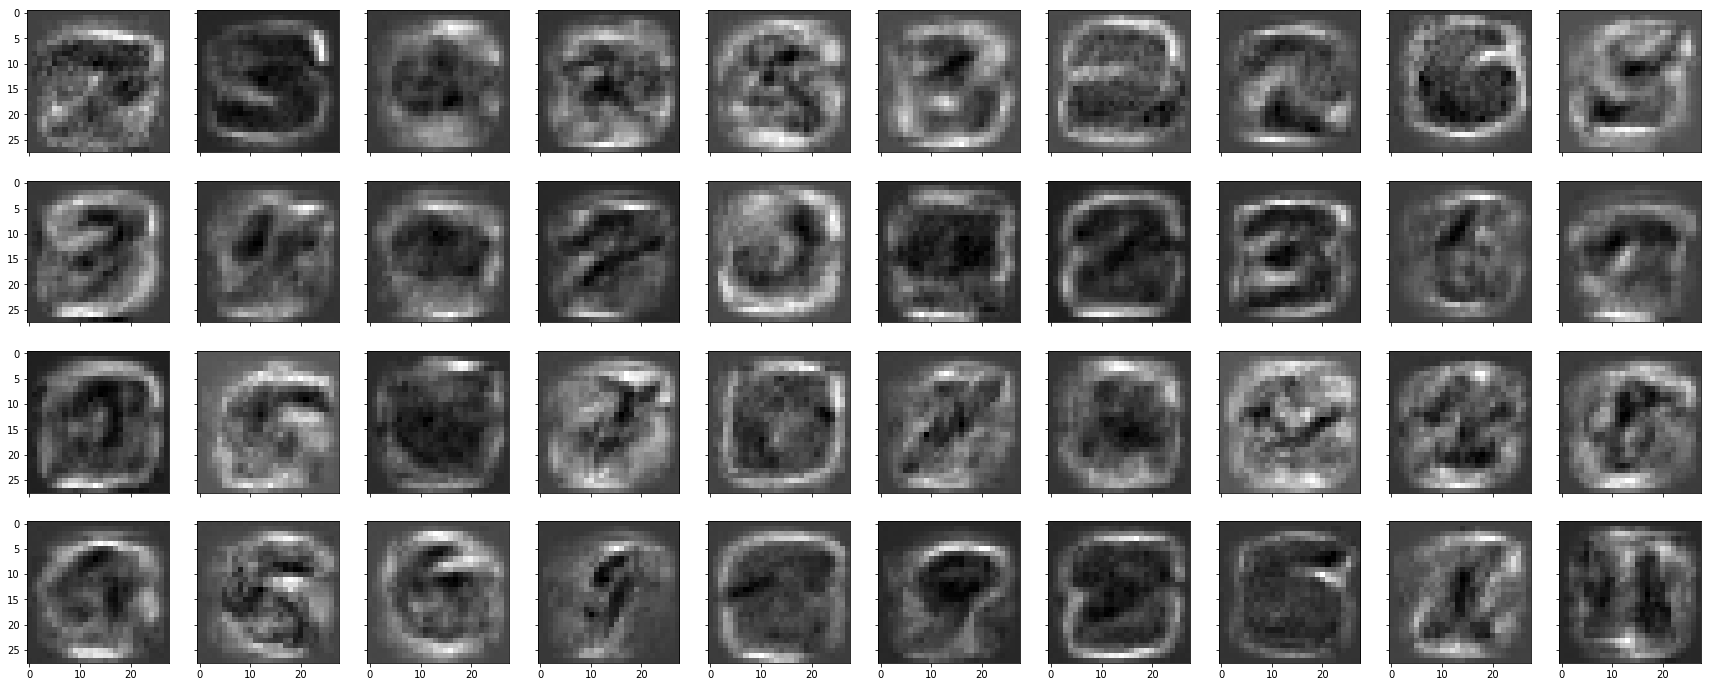

In [77]:
w = MODULE_SIZE
h = 4

f, a = plt.subplots(h, w, sharex=True, sharey=True, figsize=(w*3, h*3))

for i in range(4):
    for j in range(W.shape[-1]):
        a[i,j].imshow(W[i, :, j].reshape(IMAGE_SHAPE)*255, cmap='gray')

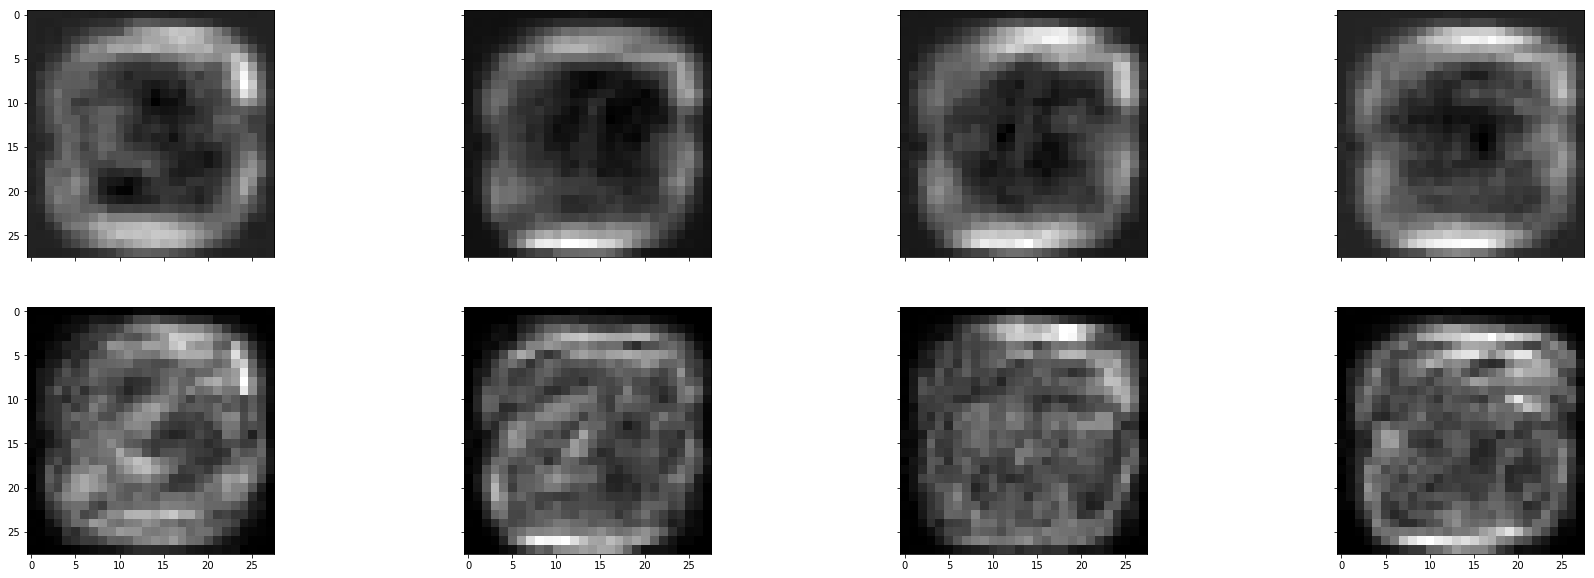

In [78]:
f, a = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(30, 10))

for i in range(4):
    a[0,i].imshow(np.mean(W[i], axis=1).reshape(IMAGE_SHAPE)*255, cmap='gray')
    a[1,i].imshow(np.std(W[i], axis=1).reshape(IMAGE_SHAPE)*255, cmap='gray')

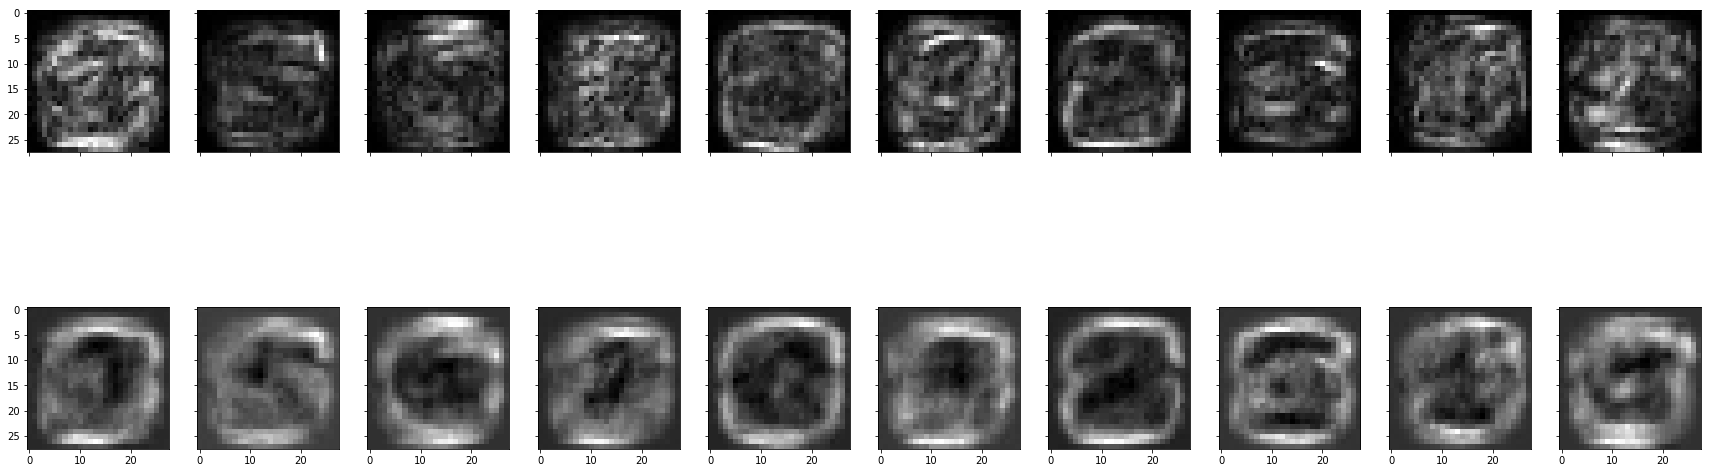

In [85]:
f, a = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(30, 10))

for i in range(W.shape[-1]):
    a[0, i].imshow(np.std(W[:,:,i], axis=0).reshape(IMAGE_SHAPE)*255, cmap='gray')
    a[1, i].imshow(np.mean(W[:,:,i], axis=0).reshape(IMAGE_SHAPE)*255, cmap='gray')

In [80]:
l_outs = np.stack(res[1:])

In [81]:
prod = [np.array([np.dot(i, j) for i, j in zip(l_outs[a], l_outs[b])]) for a, b in pairs]

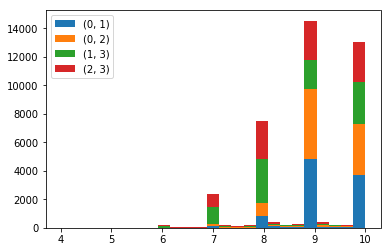

In [82]:
plt.hist(prod, bins=25, stacked=True, label=['{}'.format(i) for i in pairs])
plt.legend()
plt.show();

0


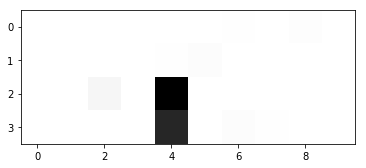

1


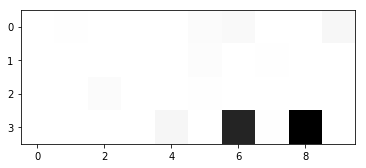

2


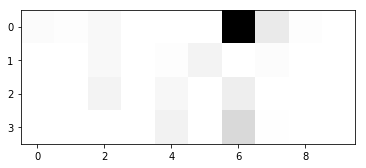

3


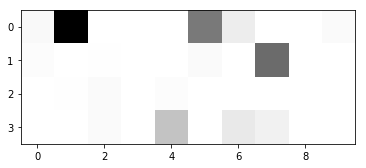

4


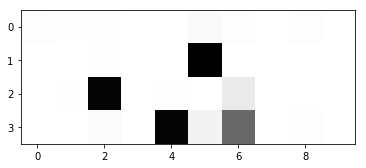

5


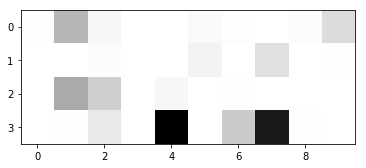

6


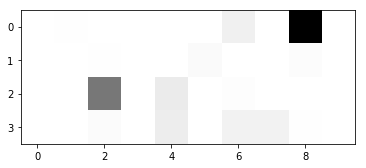

7


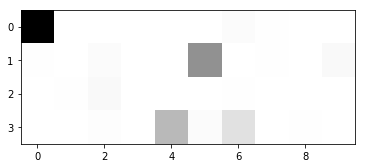

8


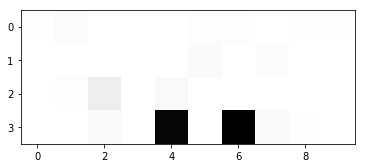

9


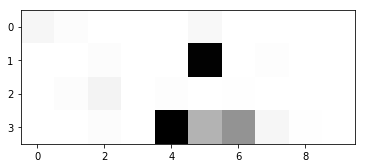

In [83]:
for i in range(10):
    slc = np.argwhere(y_test==i)[:, 0]
    print(i)
    plt.imshow(np.mean(l_outs[:,slc,:], axis=1)*255, cmap='gray')
    plt.show()

2
Label 9


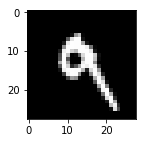

6
Label 4


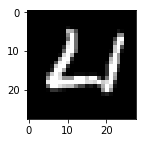

3
Label 6


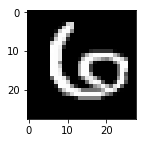

2
Label 8


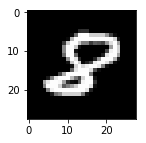

9
Label 4


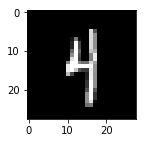

In [84]:
for i in np.argwhere(p != y_test)[:5,0]:
    print(p[i])
    printer(i, test=True)